In [12]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm  # For progress bar


In [13]:
# Import required libraries
import os

# Define the dataset paths
data_path = r'D:\university\FER\fer_ckplus_kdef'
train_dir = os.path.join(data_path, 'train')
val_dir = os.path.join(data_path, 'val')
test_dir = os.path.join(data_path, 'test')

print("Dataset paths set successfully!")


Dataset paths set successfully!


In [14]:
# Import the necessary module for data transformations
from torchvision import transforms

# Define transformations for training and validation sets with data augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 pixels
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomRotation(10),  # Random rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Adjust brightness & contrast
    transforms.RandomAffine(degrees=5),  # Random affine transformations
    transforms.ToTensor(),  # Convert to tensors
    transforms.Normalize(mean=[0.485], std=[0.229])  # Normalize for EfficientNet B0
])

print("Transformations applied successfully!")


Transformations applied successfully!


In [15]:
from torchvision import datasets

def load_data(directory):
    return datasets.ImageFolder(root=directory, transform=transform)

# Load training, validation, and test datasets
train_dataset = load_data(train_dir)
val_dataset = load_data(val_dir)
test_dataset = load_data(test_dir)


In [16]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [17]:
class CustomEfficientNet(nn.Module):
    def __init__(self):
        super(CustomEfficientNet, self).__init__()
        self.model = models.efficientnet_b0(pretrained=True)
        num_ftrs = self.model.classifier[1].in_features
        
        # Replace classifier to accommodate 8 classes
        self.model.classifier[1] = nn.Linear(num_ftrs, 8)
        self.dropout = nn.Dropout(p=0.5)
        self.batch_norm = nn.BatchNorm1d(8)

    def forward(self, x):
        x = self.model(x)
        x = self.dropout(x)
        return self.batch_norm(x)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomEfficientNet().to(device)


In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3, verbose=True)


In [19]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_val_accuracy = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct_train, total_train = 0.0, 0, 0

        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train * 100)

        val_loss, val_accuracy = validate_model(model, val_loader)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch + 1}/{num_epochs}] - '
              f'Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

        scheduler.step(val_loss)

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_model.pth')
            print("Model improved; saving checkpoint.")

    return train_losses, train_accuracies, val_losses, val_accuracies


In [20]:
def validate_model(model, val_loader):
    model.eval()
    running_loss, correct_val, total_val = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    return running_loss / len(val_loader), correct_val / total_val * 100


In [21]:
train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=100
)


100%|██████████| 781/781 [05:08<00:00,  2.53it/s]


Epoch [1/100] - Train Loss: 1.6502, Train Acc: 39.87%, Val Loss: 1.1254, Val Acc: 62.87%
Model improved; saving checkpoint.


100%|██████████| 781/781 [02:35<00:00,  5.01it/s]


Epoch [2/100] - Train Loss: 1.4110, Train Acc: 48.52%, Val Loss: 1.0245, Val Acc: 65.34%
Model improved; saving checkpoint.


100%|██████████| 781/781 [02:35<00:00,  5.03it/s]


Epoch [3/100] - Train Loss: 1.3317, Train Acc: 51.03%, Val Loss: 0.9626, Val Acc: 66.63%
Model improved; saving checkpoint.


100%|██████████| 781/781 [02:34<00:00,  5.04it/s]


Epoch [4/100] - Train Loss: 1.2847, Train Acc: 52.88%, Val Loss: 0.9267, Val Acc: 69.21%
Model improved; saving checkpoint.


100%|██████████| 781/781 [02:32<00:00,  5.11it/s]


Epoch [5/100] - Train Loss: 1.2475, Train Acc: 53.95%, Val Loss: 0.8728, Val Acc: 70.51%
Model improved; saving checkpoint.


100%|██████████| 781/781 [02:34<00:00,  5.05it/s]


Epoch [6/100] - Train Loss: 1.2161, Train Acc: 54.98%, Val Loss: 0.8505, Val Acc: 70.51%


100%|██████████| 781/781 [02:35<00:00,  5.03it/s]


Epoch [7/100] - Train Loss: 1.1914, Train Acc: 56.02%, Val Loss: 0.8635, Val Acc: 68.91%


100%|██████████| 781/781 [02:34<00:00,  5.07it/s]


Epoch [8/100] - Train Loss: 1.1659, Train Acc: 56.87%, Val Loss: 0.8320, Val Acc: 71.08%
Model improved; saving checkpoint.


100%|██████████| 781/781 [02:34<00:00,  5.06it/s]


Epoch [9/100] - Train Loss: 1.1452, Train Acc: 57.32%, Val Loss: 0.8354, Val Acc: 71.49%
Model improved; saving checkpoint.


100%|██████████| 781/781 [02:34<00:00,  5.05it/s]


Epoch [10/100] - Train Loss: 1.1280, Train Acc: 57.86%, Val Loss: 0.8104, Val Acc: 71.76%
Model improved; saving checkpoint.


100%|██████████| 781/781 [02:34<00:00,  5.06it/s]


Epoch [11/100] - Train Loss: 1.1092, Train Acc: 58.65%, Val Loss: 0.8027, Val Acc: 71.61%


100%|██████████| 781/781 [02:33<00:00,  5.10it/s]


Epoch [12/100] - Train Loss: 1.0988, Train Acc: 58.71%, Val Loss: 0.8191, Val Acc: 71.91%
Model improved; saving checkpoint.


100%|██████████| 781/781 [02:34<00:00,  5.06it/s]


Epoch [13/100] - Train Loss: 1.0775, Train Acc: 59.11%, Val Loss: 0.7974, Val Acc: 71.80%


100%|██████████| 781/781 [02:32<00:00,  5.11it/s]


Epoch [14/100] - Train Loss: 1.0665, Train Acc: 59.84%, Val Loss: 0.8226, Val Acc: 71.65%


100%|██████████| 781/781 [02:33<00:00,  5.07it/s]


Epoch [15/100] - Train Loss: 1.0424, Train Acc: 60.31%, Val Loss: 0.7878, Val Acc: 72.56%
Model improved; saving checkpoint.


100%|██████████| 781/781 [02:34<00:00,  5.04it/s]


Epoch [16/100] - Train Loss: 1.0366, Train Acc: 60.58%, Val Loss: 0.8001, Val Acc: 71.99%


100%|██████████| 781/781 [02:34<00:00,  5.05it/s]


Epoch [17/100] - Train Loss: 1.0252, Train Acc: 60.53%, Val Loss: 0.7914, Val Acc: 72.82%
Model improved; saving checkpoint.


100%|██████████| 781/781 [02:34<00:00,  5.05it/s]


Epoch [18/100] - Train Loss: 1.0137, Train Acc: 61.17%, Val Loss: 0.7736, Val Acc: 72.82%


100%|██████████| 781/781 [02:36<00:00,  5.00it/s]


Epoch [19/100] - Train Loss: 0.9959, Train Acc: 62.04%, Val Loss: 0.7958, Val Acc: 73.39%
Model improved; saving checkpoint.


100%|██████████| 781/781 [02:34<00:00,  5.06it/s]


Epoch [20/100] - Train Loss: 0.9877, Train Acc: 62.08%, Val Loss: 0.8166, Val Acc: 72.37%


100%|██████████| 781/781 [02:33<00:00,  5.08it/s]


Epoch [21/100] - Train Loss: 0.9749, Train Acc: 62.80%, Val Loss: 0.8223, Val Acc: 72.63%


100%|██████████| 781/781 [02:33<00:00,  5.09it/s]


Epoch [22/100] - Train Loss: 0.9619, Train Acc: 62.65%, Val Loss: 0.8430, Val Acc: 72.90%


100%|██████████| 781/781 [02:33<00:00,  5.09it/s]


Epoch [23/100] - Train Loss: 0.9026, Train Acc: 65.06%, Val Loss: 0.8160, Val Acc: 74.38%
Model improved; saving checkpoint.


100%|██████████| 781/781 [02:33<00:00,  5.09it/s]


Epoch [24/100] - Train Loss: 0.8727, Train Acc: 65.46%, Val Loss: 0.7980, Val Acc: 74.69%
Model improved; saving checkpoint.


100%|██████████| 781/781 [02:35<00:00,  5.03it/s]


Epoch [25/100] - Train Loss: 0.8695, Train Acc: 65.75%, Val Loss: 0.8233, Val Acc: 73.74%


100%|██████████| 781/781 [02:36<00:00,  5.00it/s]


Epoch [26/100] - Train Loss: 0.8572, Train Acc: 65.97%, Val Loss: 0.8261, Val Acc: 74.50%


100%|██████████| 781/781 [02:32<00:00,  5.11it/s]


Epoch [27/100] - Train Loss: 0.8314, Train Acc: 66.96%, Val Loss: 0.8336, Val Acc: 74.34%


100%|██████████| 781/781 [02:33<00:00,  5.08it/s]


Epoch [28/100] - Train Loss: 0.8337, Train Acc: 66.40%, Val Loss: 0.8540, Val Acc: 75.14%
Model improved; saving checkpoint.


100%|██████████| 781/781 [02:34<00:00,  5.04it/s]


Epoch [29/100] - Train Loss: 0.8158, Train Acc: 67.16%, Val Loss: 0.8474, Val Acc: 73.77%


100%|██████████| 781/781 [02:34<00:00,  5.05it/s]


Epoch [30/100] - Train Loss: 0.8144, Train Acc: 66.89%, Val Loss: 0.8510, Val Acc: 74.12%


100%|██████████| 781/781 [02:34<00:00,  5.06it/s]


Epoch [31/100] - Train Loss: 0.8011, Train Acc: 67.77%, Val Loss: 0.8902, Val Acc: 73.74%


100%|██████████| 781/781 [02:34<00:00,  5.06it/s]


Epoch [32/100] - Train Loss: 0.7969, Train Acc: 67.72%, Val Loss: 0.8638, Val Acc: 74.46%


100%|██████████| 781/781 [02:33<00:00,  5.10it/s]


Epoch [33/100] - Train Loss: 0.7852, Train Acc: 68.46%, Val Loss: 0.8614, Val Acc: 74.23%


100%|██████████| 781/781 [02:34<00:00,  5.04it/s]


Epoch [34/100] - Train Loss: 0.7994, Train Acc: 67.44%, Val Loss: 0.8408, Val Acc: 74.84%


100%|██████████| 781/781 [02:35<00:00,  5.01it/s]


Epoch [35/100] - Train Loss: 0.7866, Train Acc: 68.03%, Val Loss: 0.8419, Val Acc: 74.69%


100%|██████████| 781/781 [02:33<00:00,  5.09it/s]


Epoch [36/100] - Train Loss: 0.7767, Train Acc: 68.41%, Val Loss: 0.8806, Val Acc: 74.76%


100%|██████████| 781/781 [02:34<00:00,  5.07it/s]


Epoch [37/100] - Train Loss: 0.7869, Train Acc: 68.03%, Val Loss: 0.8537, Val Acc: 74.69%


100%|██████████| 781/781 [02:34<00:00,  5.06it/s]


Epoch [38/100] - Train Loss: 0.7913, Train Acc: 67.40%, Val Loss: 0.8764, Val Acc: 74.53%


100%|██████████| 781/781 [02:33<00:00,  5.09it/s]


Epoch [39/100] - Train Loss: 0.7806, Train Acc: 67.93%, Val Loss: 0.8711, Val Acc: 75.29%
Model improved; saving checkpoint.


100%|██████████| 781/781 [02:34<00:00,  5.06it/s]


Epoch [40/100] - Train Loss: 0.7791, Train Acc: 68.23%, Val Loss: 0.8602, Val Acc: 74.69%


100%|██████████| 781/781 [02:34<00:00,  5.05it/s]


Epoch [41/100] - Train Loss: 0.7780, Train Acc: 68.18%, Val Loss: 0.8721, Val Acc: 74.61%


100%|██████████| 781/781 [02:36<00:00,  5.00it/s]


Epoch [42/100] - Train Loss: 0.7741, Train Acc: 68.60%, Val Loss: 0.8699, Val Acc: 74.84%


100%|██████████| 781/781 [02:34<00:00,  5.05it/s]


Epoch [43/100] - Train Loss: 0.7800, Train Acc: 67.84%, Val Loss: 0.8820, Val Acc: 74.76%


100%|██████████| 781/781 [02:36<00:00,  5.00it/s]


Epoch [44/100] - Train Loss: 0.7699, Train Acc: 68.58%, Val Loss: 0.8457, Val Acc: 74.99%


100%|██████████| 781/781 [02:33<00:00,  5.09it/s]


Epoch [45/100] - Train Loss: 0.7776, Train Acc: 68.44%, Val Loss: 0.8691, Val Acc: 74.46%


100%|██████████| 781/781 [02:33<00:00,  5.10it/s]


Epoch [46/100] - Train Loss: 0.7742, Train Acc: 68.29%, Val Loss: 0.8783, Val Acc: 74.50%


100%|██████████| 781/781 [02:34<00:00,  5.05it/s]


Epoch [47/100] - Train Loss: 0.7877, Train Acc: 68.10%, Val Loss: 0.8890, Val Acc: 74.65%


100%|██████████| 781/781 [02:35<00:00,  5.02it/s]


Epoch [48/100] - Train Loss: 0.7816, Train Acc: 67.86%, Val Loss: 0.8536, Val Acc: 75.10%


100%|██████████| 781/781 [02:34<00:00,  5.05it/s]


Epoch [49/100] - Train Loss: 0.7733, Train Acc: 68.53%, Val Loss: 0.8810, Val Acc: 74.34%


100%|██████████| 781/781 [02:35<00:00,  5.04it/s]


Epoch [50/100] - Train Loss: 0.7721, Train Acc: 68.45%, Val Loss: 0.8678, Val Acc: 75.10%


100%|██████████| 781/781 [02:34<00:00,  5.05it/s]


Epoch [51/100] - Train Loss: 0.7798, Train Acc: 68.27%, Val Loss: 0.8771, Val Acc: 74.80%


100%|██████████| 781/781 [02:33<00:00,  5.09it/s]


Epoch [52/100] - Train Loss: 0.7697, Train Acc: 68.40%, Val Loss: 0.8719, Val Acc: 74.76%


100%|██████████| 781/781 [02:36<00:00,  5.00it/s]


Epoch [53/100] - Train Loss: 0.7783, Train Acc: 67.82%, Val Loss: 0.8612, Val Acc: 74.34%


100%|██████████| 781/781 [02:35<00:00,  5.04it/s]


Epoch [54/100] - Train Loss: 0.7780, Train Acc: 68.08%, Val Loss: 0.8663, Val Acc: 74.76%


100%|██████████| 781/781 [02:33<00:00,  5.08it/s]


Epoch [55/100] - Train Loss: 0.7723, Train Acc: 68.42%, Val Loss: 0.8767, Val Acc: 74.42%


100%|██████████| 781/781 [02:34<00:00,  5.04it/s]


Epoch [56/100] - Train Loss: 0.7836, Train Acc: 67.70%, Val Loss: 0.8649, Val Acc: 74.72%


100%|██████████| 781/781 [02:34<00:00,  5.06it/s]


Epoch [57/100] - Train Loss: 0.7719, Train Acc: 68.69%, Val Loss: 0.9010, Val Acc: 74.65%


100%|██████████| 781/781 [02:34<00:00,  5.06it/s]


Epoch [58/100] - Train Loss: 0.7737, Train Acc: 68.70%, Val Loss: 0.8822, Val Acc: 74.72%


100%|██████████| 781/781 [02:35<00:00,  5.03it/s]


Epoch [59/100] - Train Loss: 0.7782, Train Acc: 68.22%, Val Loss: 0.8559, Val Acc: 74.84%


100%|██████████| 781/781 [02:35<00:00,  5.03it/s]


Epoch [60/100] - Train Loss: 0.7737, Train Acc: 68.57%, Val Loss: 0.8566, Val Acc: 74.80%


100%|██████████| 781/781 [02:33<00:00,  5.09it/s]


Epoch [61/100] - Train Loss: 0.7684, Train Acc: 68.67%, Val Loss: 0.8675, Val Acc: 74.61%


100%|██████████| 781/781 [02:33<00:00,  5.08it/s]


Epoch [62/100] - Train Loss: 0.7710, Train Acc: 68.47%, Val Loss: 0.8830, Val Acc: 74.61%


100%|██████████| 781/781 [02:35<00:00,  5.01it/s]


Epoch [63/100] - Train Loss: 0.7740, Train Acc: 68.25%, Val Loss: 0.8879, Val Acc: 74.99%


100%|██████████| 781/781 [02:35<00:00,  5.02it/s]


Epoch [64/100] - Train Loss: 0.7702, Train Acc: 68.56%, Val Loss: 0.8890, Val Acc: 74.27%


100%|██████████| 781/781 [02:34<00:00,  5.07it/s]


Epoch [65/100] - Train Loss: 0.7792, Train Acc: 68.26%, Val Loss: 0.8882, Val Acc: 74.65%


100%|██████████| 781/781 [02:35<00:00,  5.03it/s]


Epoch [66/100] - Train Loss: 0.7871, Train Acc: 67.52%, Val Loss: 0.8739, Val Acc: 74.61%


100%|██████████| 781/781 [02:34<00:00,  5.04it/s]


Epoch [67/100] - Train Loss: 0.7772, Train Acc: 68.25%, Val Loss: 0.8605, Val Acc: 74.57%


100%|██████████| 781/781 [02:33<00:00,  5.09it/s]


Epoch [68/100] - Train Loss: 0.7818, Train Acc: 68.00%, Val Loss: 0.8959, Val Acc: 74.88%


100%|██████████| 781/781 [02:36<00:00,  4.98it/s]


Epoch [69/100] - Train Loss: 0.7677, Train Acc: 68.50%, Val Loss: 0.8801, Val Acc: 74.15%


100%|██████████| 781/781 [02:35<00:00,  5.03it/s]


Epoch [70/100] - Train Loss: 0.7836, Train Acc: 67.66%, Val Loss: 0.8764, Val Acc: 75.64%
Model improved; saving checkpoint.


100%|██████████| 781/781 [02:33<00:00,  5.07it/s]


Epoch [71/100] - Train Loss: 0.7694, Train Acc: 68.53%, Val Loss: 0.8900, Val Acc: 75.10%


100%|██████████| 781/781 [02:34<00:00,  5.06it/s]


Epoch [72/100] - Train Loss: 0.7794, Train Acc: 68.21%, Val Loss: 0.8759, Val Acc: 74.42%


100%|██████████| 781/781 [02:34<00:00,  5.06it/s]


Epoch [73/100] - Train Loss: 0.7679, Train Acc: 68.47%, Val Loss: 0.8681, Val Acc: 74.57%


100%|██████████| 781/781 [02:34<00:00,  5.05it/s]


Epoch [74/100] - Train Loss: 0.7798, Train Acc: 68.15%, Val Loss: 0.8748, Val Acc: 74.88%


100%|██████████| 781/781 [02:36<00:00,  4.99it/s]


Epoch [75/100] - Train Loss: 0.7807, Train Acc: 68.20%, Val Loss: 0.8996, Val Acc: 74.50%


100%|██████████| 781/781 [02:36<00:00,  5.01it/s]


Epoch [76/100] - Train Loss: 0.7698, Train Acc: 68.80%, Val Loss: 0.8664, Val Acc: 75.29%


100%|██████████| 781/781 [02:33<00:00,  5.09it/s]


Epoch [77/100] - Train Loss: 0.7653, Train Acc: 68.78%, Val Loss: 0.9182, Val Acc: 74.46%


100%|██████████| 781/781 [02:34<00:00,  5.07it/s]


Epoch [78/100] - Train Loss: 0.7726, Train Acc: 68.51%, Val Loss: 0.8766, Val Acc: 75.10%


100%|██████████| 781/781 [02:35<00:00,  5.03it/s]


Epoch [79/100] - Train Loss: 0.7611, Train Acc: 68.92%, Val Loss: 0.8720, Val Acc: 74.65%


100%|██████████| 781/781 [02:35<00:00,  5.02it/s]


Epoch [80/100] - Train Loss: 0.7688, Train Acc: 68.77%, Val Loss: 0.9041, Val Acc: 73.74%


100%|██████████| 781/781 [02:35<00:00,  5.02it/s]


Epoch [81/100] - Train Loss: 0.7663, Train Acc: 68.77%, Val Loss: 0.8593, Val Acc: 74.99%


100%|██████████| 781/781 [02:35<00:00,  5.03it/s]


Epoch [82/100] - Train Loss: 0.7677, Train Acc: 68.49%, Val Loss: 0.9159, Val Acc: 74.04%


100%|██████████| 781/781 [02:34<00:00,  5.06it/s]


Epoch [83/100] - Train Loss: 0.7735, Train Acc: 68.46%, Val Loss: 0.8690, Val Acc: 75.07%


100%|██████████| 781/781 [02:33<00:00,  5.08it/s]


Epoch [84/100] - Train Loss: 0.7692, Train Acc: 68.24%, Val Loss: 0.8738, Val Acc: 74.80%


100%|██████████| 781/781 [02:36<00:00,  5.00it/s]


Epoch [85/100] - Train Loss: 0.7713, Train Acc: 68.36%, Val Loss: 0.8366, Val Acc: 74.80%


100%|██████████| 781/781 [02:37<00:00,  4.96it/s]


Epoch [86/100] - Train Loss: 0.7704, Train Acc: 68.62%, Val Loss: 0.8753, Val Acc: 75.07%


100%|██████████| 781/781 [02:34<00:00,  5.06it/s]


Epoch [87/100] - Train Loss: 0.7834, Train Acc: 67.75%, Val Loss: 0.8905, Val Acc: 75.45%


100%|██████████| 781/781 [02:39<00:00,  4.89it/s]


Epoch [88/100] - Train Loss: 0.7670, Train Acc: 68.65%, Val Loss: 0.8604, Val Acc: 74.99%


100%|██████████| 781/781 [06:11<00:00,  2.10it/s]


Epoch [89/100] - Train Loss: 0.7678, Train Acc: 68.49%, Val Loss: 0.8760, Val Acc: 74.27%


100%|██████████| 781/781 [10:11<00:00,  1.28it/s]


Epoch [90/100] - Train Loss: 0.7758, Train Acc: 68.18%, Val Loss: 0.8716, Val Acc: 74.76%


100%|██████████| 781/781 [05:05<00:00,  2.56it/s]


Epoch [91/100] - Train Loss: 0.7822, Train Acc: 68.06%, Val Loss: 0.8839, Val Acc: 74.42%


100%|██████████| 781/781 [02:35<00:00,  5.02it/s]


Epoch [92/100] - Train Loss: 0.7771, Train Acc: 68.26%, Val Loss: 0.8703, Val Acc: 74.84%


100%|██████████| 781/781 [02:34<00:00,  5.04it/s]


Epoch [93/100] - Train Loss: 0.7779, Train Acc: 68.04%, Val Loss: 0.8479, Val Acc: 75.10%


100%|██████████| 781/781 [02:36<00:00,  4.98it/s]


Epoch [94/100] - Train Loss: 0.7708, Train Acc: 68.59%, Val Loss: 0.8694, Val Acc: 74.15%


100%|██████████| 781/781 [02:34<00:00,  5.07it/s]


Epoch [95/100] - Train Loss: 0.7844, Train Acc: 67.98%, Val Loss: 0.8707, Val Acc: 74.65%


100%|██████████| 781/781 [02:34<00:00,  5.04it/s]


Epoch [96/100] - Train Loss: 0.7754, Train Acc: 68.27%, Val Loss: 0.8876, Val Acc: 74.84%


100%|██████████| 781/781 [02:34<00:00,  5.05it/s]


Epoch [97/100] - Train Loss: 0.7700, Train Acc: 68.41%, Val Loss: 0.8969, Val Acc: 73.85%


100%|██████████| 781/781 [02:33<00:00,  5.09it/s]


Epoch [98/100] - Train Loss: 0.7650, Train Acc: 68.96%, Val Loss: 0.8776, Val Acc: 75.29%


100%|██████████| 781/781 [02:32<00:00,  5.14it/s]


Epoch [99/100] - Train Loss: 0.7725, Train Acc: 68.14%, Val Loss: 0.8964, Val Acc: 74.50%


100%|██████████| 781/781 [02:32<00:00,  5.12it/s]


Epoch [100/100] - Train Loss: 0.7752, Train Acc: 67.92%, Val Loss: 0.8662, Val Acc: 74.72%


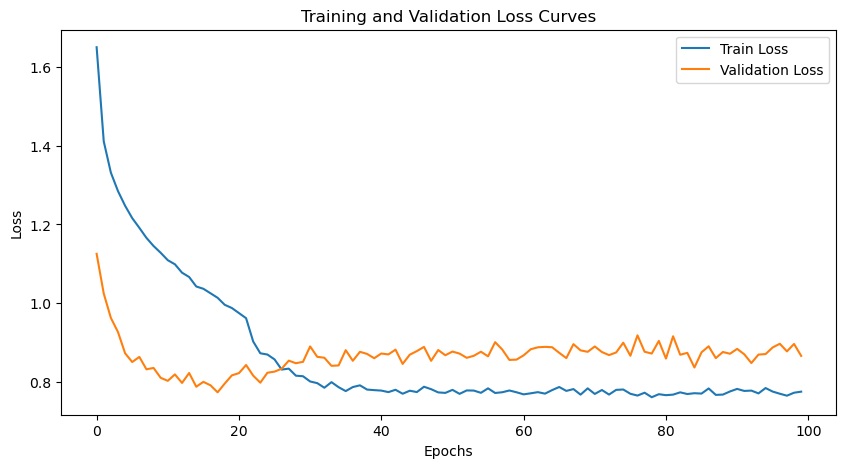

In [22]:
def plot_loss_curves(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curves')
    plt.legend()
    plt.show()

plot_loss_curves(train_losses, val_losses)


In [23]:
def test_model(model, test_loader):
    model.eval()
    all_labels, all_predictions = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    return np.array(all_labels), np.array(all_predictions)

true_labels, predictions = test_model(model, test_loader)


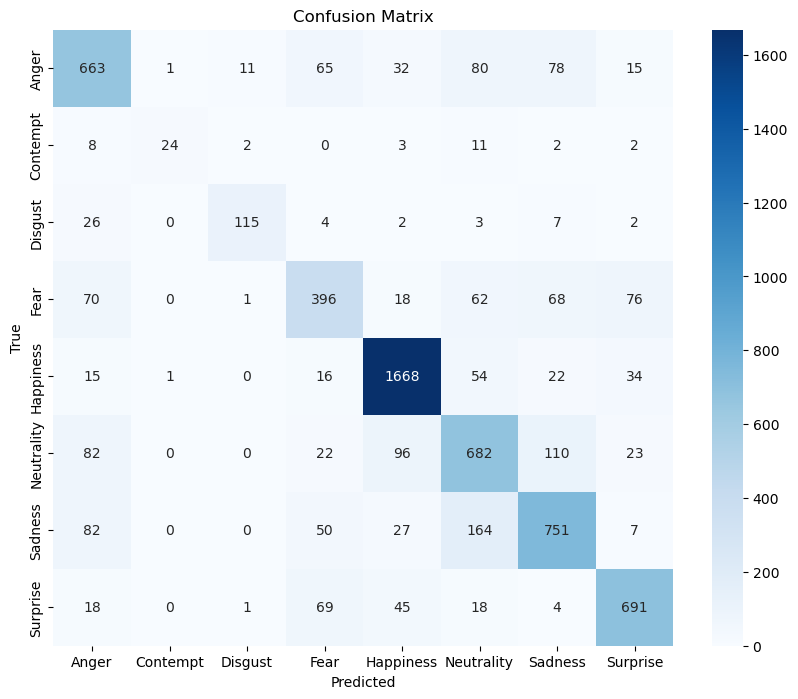

              precision    recall  f1-score   support

       Anger       0.69      0.70      0.69       945
    Contempt       0.92      0.46      0.62        52
     Disgust       0.88      0.72      0.80       159
        Fear       0.64      0.57      0.60       691
   Happiness       0.88      0.92      0.90      1810
  Neutrality       0.64      0.67      0.65      1015
     Sadness       0.72      0.69      0.71      1081
    Surprise       0.81      0.82      0.81       846

    accuracy                           0.76      6599
   macro avg       0.77      0.70      0.72      6599
weighted avg       0.76      0.76      0.75      6599



In [24]:
def plot_confusion_matrix(true_labels, predictions, class_names):
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

class_names = ['Anger', 'Contempt', 'Disgust','Fear', 'Happiness', 'Neutrality', 'Sadness', 'Surprise']

plot_confusion_matrix(true_labels, predictions, class_names)

print(classification_report(true_labels, predictions, target_names=class_names))
